# Clustering and association rule mining
## Part 1: Finding optimal hub locations
## 1. Business understanding
The goal of the analysis is to declare the optimal coordinates for the drone hubs using the customer locations.
## 2. Data understanding
The dataset has three columns
- clientid
- x
- y

Where x and y indicates customers' location coordinates
## 3. Data preparation
Visualizing the client locations in a two-dimensional scatterplot.

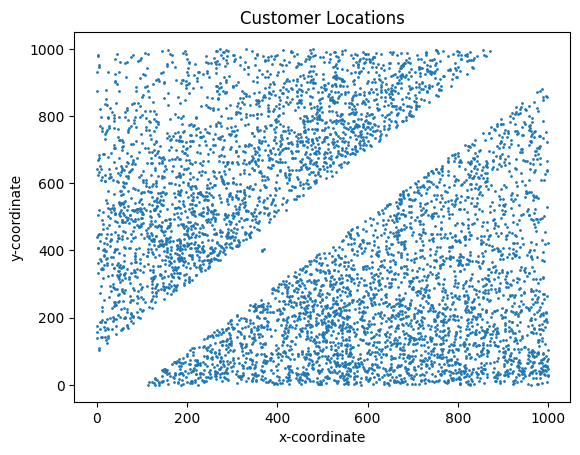

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('datasets/drone_cust_locations.csv', sep=';').drop('clientid', axis=1)

X = df['x']
y = df['y']

plt.scatter(X, y, s=1)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.title('Customer Locations')
plt.show()


The scatterplot shows that the customer locations are divided by a diagonal gap. A geographical interpretation could be a large river.

## 4. Modelling
Calculating the optimal locations for three drone depots using K-means clustering.

In [2]:
from sklearn.cluster import KMeans

model = KMeans(init='random', n_clusters=3, random_state=42)
model.fit(df)

model.cluster_centers_

array([[702.08109226, 211.2703835 ],
       [198.44098904, 383.25861847],
       [548.20586479, 787.2788963 ]])

And below is the calculations for the optimal locations for ten drone depots using K-means clustering.

In [3]:
model = KMeans(init='random', n_clusters=10, random_state=42)
model.fit(df)

model.cluster_centers_

array([[881.10218422, 635.21820804],
       [452.0773205 , 767.46252873],
       [732.73746126, 401.79973121],
       [308.10079757,  87.32225671],
       [849.63070889, 128.41204786],
       [648.68575066, 895.59442536],
       [107.44746876, 365.00430943],
       [152.50728205, 799.99674306],
       [547.0171653 , 171.36638491],
       [250.11367099, 534.29876157]])

Creating an additional column that shows the nearest depot id for each customer location.

In [4]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

df_with_clusters.head(10)

,x,y,depot
0,622.771572,164.857623,8
1,416.357298,630.193634,1
2,292.735020,567.333231,9
3,737.211288,166.225676,4
4,540.475375,682.912298,1
5,535.469492,318.439661,8
6,640.380050,870.833221,5
7,235.772075,359.048203,6
8,481.896884,661.491838,1
9,730.032789,312.177817,2


Visualizing the client location scatterplot with colourings indicating the depot.

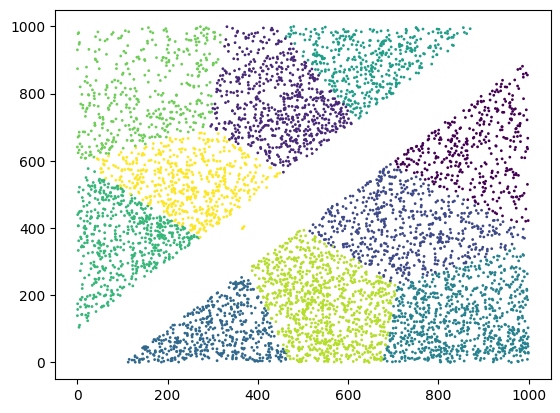

In [5]:
plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

## 5. Evaluation
Performance evaluation

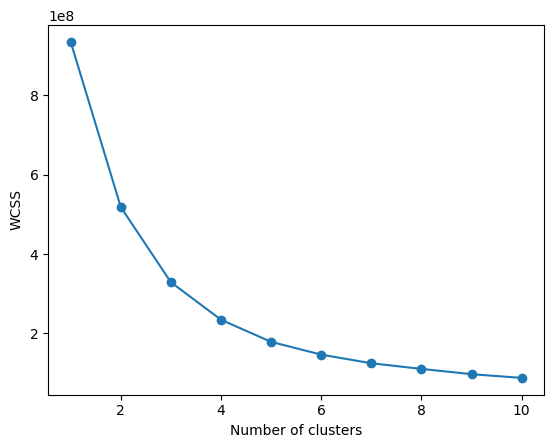

In [6]:
import matplotlib.pyplot as plt

wcss = []
for i in range(1,11):
    model = KMeans(init='random', n_clusters=i, random_state=42).fit(df)
    wcss.append(model.inertia_)

plt.plot(range(1,11), wcss, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The elbow method shows that the optimal number of clusters is 4. After 4, the decrease in inertia is not significant.

# Calculating the silhouette score

In our performance evaluation phase, we supplemented the elbow method with silhouette score analysis to provide a more robust assessment of our clustering solution. The silhouette score measures how well-defined our clusters are by evaluating both cluster cohesion and separation. Our score (0.366) indicates that our clusters are well-defined and distinct from each other.

In [7]:
from sklearn.metrics import silhouette_score

model = KMeans(init='random', n_clusters=20, random_state=42)

model.fit(df)
model.cluster_centers_

print(f'Silhouette score: {silhouette_score(df, model.labels_)}')

Silhouette score: 0.3737793401455137


## 6. Deployment
Using ten depots


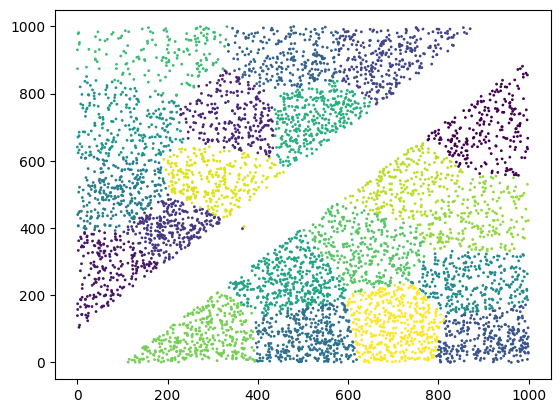

In [8]:
clusters = model.predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

We get a runtime of 225 milliseconds when using ten depots compared to 335 milliseconds when doing twenty depots. We can clearly see a big computation time increase with more depots. The scatterplot shows the customer locations with ten depots. 

Setting depots with agglomerative clustering

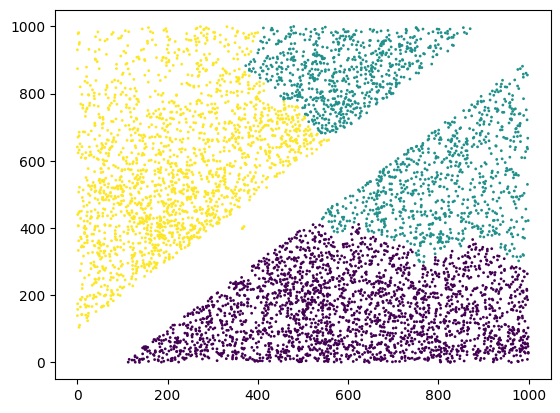

In [9]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=3)
clusters = model.fit_predict(df)

df_with_clusters = df.copy()
df_with_clusters['depot'] = clusters

plt.scatter(df_with_clusters['x'], df_with_clusters['y'], c=df_with_clusters['depot'], s=1)

## Part 2: Finding interesting relationships between product groups
## 1. Business Understanding
In this part, the task is to analyze the item sets and their correlations with others.
## 2. Data understanding
In this analysis, the dataset is a large list of sales data with 100,000 rows. There are two types of columns in the dataset:
- `ID` for the transaction ID
- `Prod1, ..., Prod20` indicates the one type of the product. In the rows these columns are marked with values 0 or 1 where 1 means that the one type of product has been purchased and 0 for not.
## 3. Data preparation
Reading the dataframe.


In [10]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv('datasets/drone_prod_groups(1).csv', sep=',', dtype=int).drop('ID', axis=1)
df = df.replace({1: True, 0: False})
df

ModuleNotFoundError: No module named 'mlxtend'

## 4. Modelling
Applying the dataset into apriori.

In [ ]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True)
frequent_itemsets

This shows the most frequent items or item combinations with highest support. For example Prod19 is the most frequently sold item with 0.20 support and the most frequent combination is Prod19 and Prod20.
## 5. Evaluation

In [ ]:
# generate association rules

rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5)

# sort in descending order of confidence
rules = rules.sort_values(by='confidence', ascending=False)


rules = rules.drop(rules.columns[11:], axis=1)

rules

Antecedent shows the item(s) that are bought and consequent shows the item(s) that are bought with the antecedent.

The data is sorted by confidence, meaning the probability of buying the consequent item given that the antecedent item is bought. For example:
- A customer who buys Prod15 will buy Prod9 with roughly a 94% probability.
- A customer who buys Prod20 will buy Prod19 with roughly a 91% probability.
    
This means that the company should consider recommending Prod9 to customers who buy Prod15 and recommend Prod19 to customers who buy Prod20 and so on.